# Feature selection for scRNA-seq data
**Author**: Adam Klie (last modified: 10/08/2023)<br>
***
**Description**: This script performs multiple feature selection methods on scRNA-seq data. The methods are:

In [1]:
# Imports
import os
import pandas as pd
import scanpy as sc
import anndata2ri
import logging
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

by .GlobalEnv when processing object ‘.pbd_env’


In [2]:
# Paths
input_h5ad_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/09Oct23/dm32a/4_normalization_scRNAseq.h5ad"
outdir_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/09Oct23/dm32a"

In [3]:
# Define run parameters
output_prefix = "5_feature-selection_scRNAseq"
layers_to_calc_variance = ["log1p_norm", "scran_normalization", "depth_normalization"]

In [4]:
# Read in h5ad
adata = sc.read_h5ad(input_h5ad_path)
adata

AnnData object with n_obs × n_vars = 4054 × 15708
    obs: 'n_genes', 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'at

# Deviance based feature selection

In [5]:
# make a slimmed down version
adata_ = sc.AnnData(adata.X.copy())
adata_.obs_names = adata.obs_names.copy()
adata_.var_names = adata.var_names.copy()

In [6]:
%%R
library(scry)

In [7]:
# Current version of anndata2ri requires this
adata_.X = adata_.X.astype(np.float32)

In [8]:
# Put the data into R
ro.globalenv["adata_"] = adata_

In [9]:
%%R
sce = devianceFeatureSelection(adata_, assay="X")

In [10]:
# Grab the deviances from R
binomial_deviance = ro.r("rowData(sce)$binomial_deviance").T

In [71]:
# Annotate highly deviant genes
idx = binomial_deviance.argsort()[-4000:]
mask = np.zeros(adata.var_names.shape, dtype=bool)
mask[idx] = True
adata.var["highly_deviant"] = mask
adata.var["binomial_deviance"] = binomial_deviance

In [74]:
# Read in gene log
gene_log = pd.read_csv(os.path.join(outdir_path, "gene_log.csv"), index_col=0)

In [75]:
# Save the deviant genes
deviant_genes = adata.var[adata.var.highly_deviant]
deviant_genes.to_csv(os.path.join(outdir_path, "highly_deviant_genes.tsv"), sep="\t")

In [76]:
# Add to gene log
gene_log["num_deviant_genes"] = deviant_genes.shape[0]

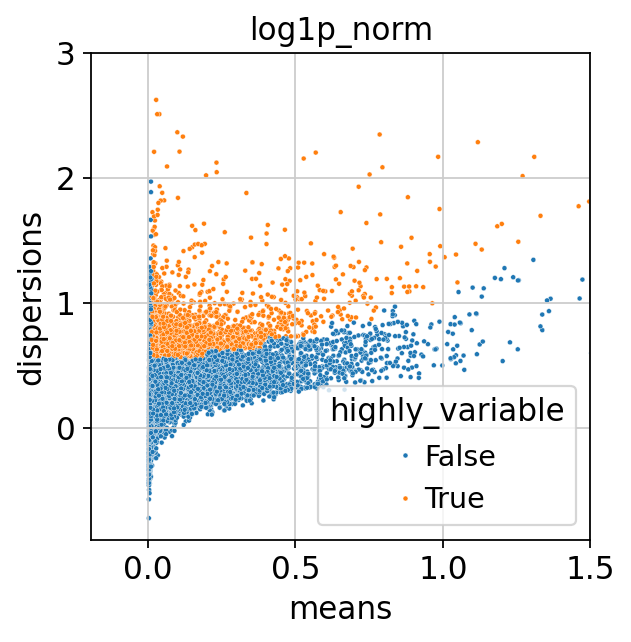

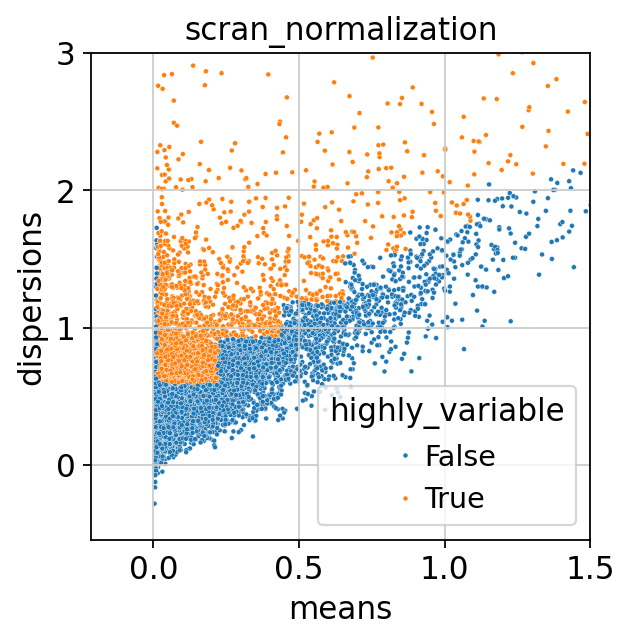

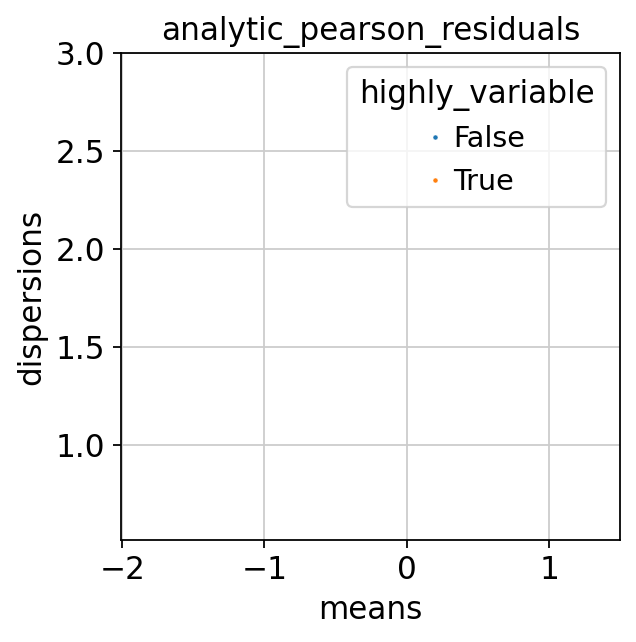

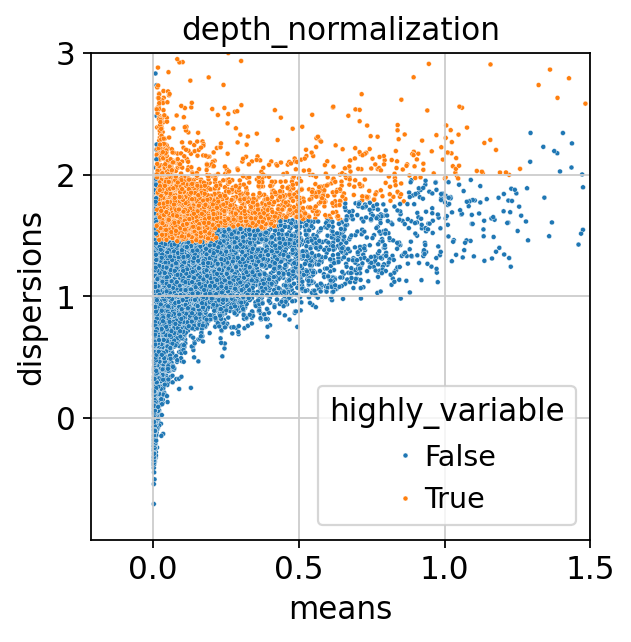

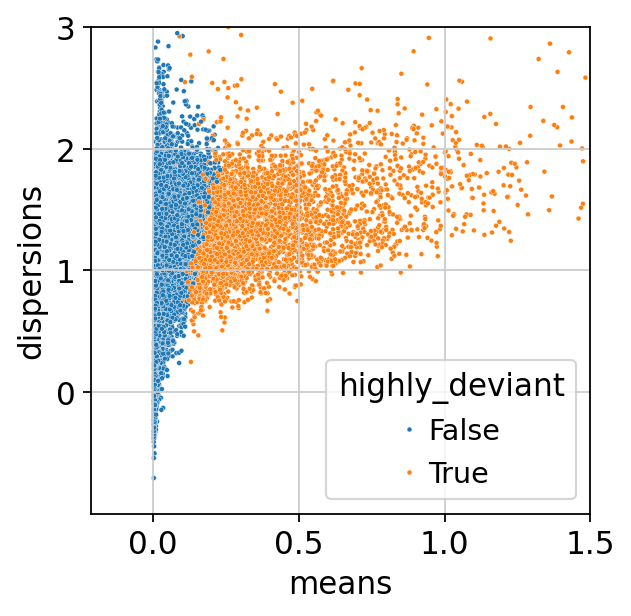

In [80]:
# Calculate dispersions and means on normalized data
if len(layers_to_calc_variance) > 1:

    for layer in layers_to_calc_variance:

        # Calculate dispersions and means on scran-normalized data
        sc.pp.highly_variable_genes(adata, layer=layer)
        adata.var[f"{layer}_highly_variable"] = adata.var["highly_variable"].copy()

         # Make a scatter plot of highly variable genes
        ax = sns.scatterplot(data=adata.var, x="means", y="dispersions", hue="highly_variable", s=5)
        ax.set_xlim(None, 1.5)
        ax.set_ylim(None, 3)
        ax.set_title(layer)
        plt.show()

        # Add to gene log
        variable_genes = adata.var[adata.var[f"{layer}_highly_variable"]].index.to_series()
        variable_genes.to_csv(os.path.join(outdir_path, f"{layer}_highly_variable_genes.tsv"), sep="\t", index=False, header=False)
        gene_log[f"num_{layer}_variable_genes"] = variable_genes.shape[0]

    # Plot the highly deviant genes
    ax = sns.scatterplot(data=adata.var, x="means", y="dispersions", hue="highly_deviant", s=5)
    ax.set_xlim(None, 1.5)
    ax.set_ylim(None, 3)
    plt.show()

In [73]:
# Save the filtered data.
adata.write(os.path.join(outdir_path, "5_feature_selection_scRNAseq.h5ad"))

# DONE!

---

```bash
input_h5ad_path=/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/09Oct23/dm32a/4_normalization_scRNAseq.h5ad
outdir_path=/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/09Oct23/dm32a
layers_to_calc_variance="log1p_norm scran_normalization depth_normalization"

cd /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/bin/data_annotation/scanpy

cmd="python 5_feature-selection_scRNAseq.py \
--input_h5ad_path $input_h5ad_path \
--outdir_path $outdir_path \
--layers_to_calc_variance $layers_to_calc_variance"

echo $cmd
```